# Pediatric Bone Marrow Transplant Survival Classification

### Introduction
Unmanipulated allogeneic hematopoietic stem cell transplantation is a commonly used and effective treatment for children with various hematologic diseases, both malignant and nonmalignant. This treatment functions by transplanting healthy CD34+ stem cells from an unrelated donor to the afflicted child. It has been proven in Kałwak et al.’s 2010 study that higher doses of CD34+ stem cells are associated with a higher chance of survival for the recipient and a lower chance of relapse, without increased risks of severe side effects. Prior research indicates that certain factors are influential in predicting a child’s chance of survival following the transplant, including the age of the donor and recipient, the recipient’s body mass, and the dosage of CD34+ stem cells administered to the patient. 

Using the bone marrow transplant dataset available to us, can we predict whether a future pediatric patient with a hematologic disease who receives a bone marrow transplant is likely to survive or not based on the predictors of donor age, recipient age, CD34+ cell dose, and body mass?

The dataset describes cases of pediatric patients with malignant hematologic diseases such as acute lymphoblastic leukemia, acute myelogenous leukemia, chronic myelogenous leukemia, and myelodysplastic syndrome as well as nonmalignant hematologic diseases such as severe aplastic anemia, Fanconi anemia, and X-linked adrenoleukodystrophy. All of the patients in the dataset had unaltered allogeneic unrelated donor hematopoietic stem cell transplants. These are the five different predictors used to answer our question:
* Donor_Age - Age of the donor when hematopoietic stem cells were removed 
* Recipient_Age - Age of the recipient when the hematopoietic stem cells were transplanted
* CD34_Dose - CD34+ cell dose per kg of recipient body weight (10^6 cells/kg)
* Body_Mass - Body mass of the recipient at the time of transplantation,
* Survival_Status - The survival status of the recipient after the transplant (0 = deceased, 1 = survived)

### Methods and Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(GGally)
library(ggplot2)
set.seed(10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the dataset into R
set.seed(10) #to ensure that our data is reproducible
bone_marrow <- read_csv("https://raw.githubusercontent.com/rishiiii3/dsci-100-2023S-group-67/main/bone-marrow.arff", 
                        skip = 108, col_names = FALSE) 
head(bone_marrow)

Rows: 187 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): X8, X9, X10, X11, X12, X13, X14, X20, X21, X28, X30, X31, X32
dbl (24): X1, X2, X3, X4, X5, X6, X7, X15, X16, X17, X18, X19, X22, X23, X24...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,22.83014,0,1,0,1,1,1,0,⋯,1,7.20,1.33876,5.38,35,19,51,32,999,0
1,0,23.34247,0,1,0,-1,-1,1,0,⋯,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
1,0,26.39452,0,1,0,-1,-1,1,0,⋯,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
0,0,39.68493,1,1,0,1,2,1,1,⋯,?,4.25,29.481647,0.14,50,23,29,19,53,1
0,1,33.35890,0,0,0,1,2,0,1,⋯,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0
1,0,27.39178,0,0,0,2,0,1,1,⋯,1,3.27,8.412758,0.39,40,16,70,1000000,2800,0


*Table 1. Initial dataset prior to cleaning or wrangling*

In [3]:
#cleaning and wrangling the dataset into tidy form
bone_marrow_selected <- select(bone_marrow, X3, X23, X29, X32,X37) |> 
rename(  Donor_Age = X3 ,
         Recipient_Age = X23,
         CD34_Dose = X29,
         Body_Mass = X32,
         Survival_Status = X37) |>
mutate(Survival_Status = as_factor(Survival_Status)) |>
mutate(Body_Mass = as.numeric(Body_Mass))
bone_marrow_selected[bone_marrow_selected == "?"] <- "NA" #this step was used because researchers used ? instead of NA
bone_marrow_selected |> is.na()|> sum()

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] 2

Here, we selected the columns we were interested in and then changed their names to make them easier to understand. After that, we converted the survival status column to a factor vector and the body mass column from a character vector to a numeric vector so that we could easily and sensically manipulate the data. We found that there were 2 rows that contained missing data.

In [4]:
bone_marrow_clean <- bone_marrow_selected |> drop_na(Donor_Age:Survival_Status)
head(bone_marrow_clean)

Donor_Age,Recipient_Age,CD34_Dose,Body_Mass,Survival_Status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
22.83014,9.6,7.20,35.0,0
23.34247,4.0,4.50,20.6,1
26.39452,6.6,7.94,23.4,1
39.68493,18.1,4.25,50.0,1
33.35890,1.3,51.85,9.0,0
27.39178,8.9,3.27,40.0,0


*Table 2. Tidied dataset used for data analysis*

The data above is in a tidy format.

In [5]:
#splitting data into training and testing
bone_marrow_split <- initial_split(bone_marrow_clean, prop= 0.75, strata = Survival_Status)
bone_marrow_train <- training(bone_marrow_split)
bone_marrow_test <- testing(bone_marrow_split)

We split our data into training and testing to be able to evaluate the accuracy of our model.

In [6]:
mean_predictors <- bone_marrow_train |> 
summarize(across(Donor_Age:Body_Mass, mean, na.rm = TRUE))
mean_predictors

Donor_Age,Recipient_Age,CD34_Dose,Body_Mass
<dbl>,<dbl>,<dbl>,<dbl>
33.67755,9.928261,11.49343,35.64022


*Table 3. Mean values of all predictors*

Here, we summarized the training data by the mean values for each predictor in the dataset. This helped us understand how our data is distributed and also that we would have to standardize it when performing data analysis.

In [7]:
#summarizing the training data by counting survival status observations
obs_per_class <- bone_marrow_train |> 
    group_by(Survival_Status) |> 
    summarise(count = n())
obs_per_class

Survival_Status,count
<fct>,<int>
0,76
1,62


*Table 4. Number of observations in each class of the target variable*

These are the number of observations for each class, where 0 represents a deceased patient and 1 represents a patient who survived. We observed that there were slightly more cases of deceased patients than patients who survived, although we do not believe that this difference is significant enough to conduct upsampling on the data.

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



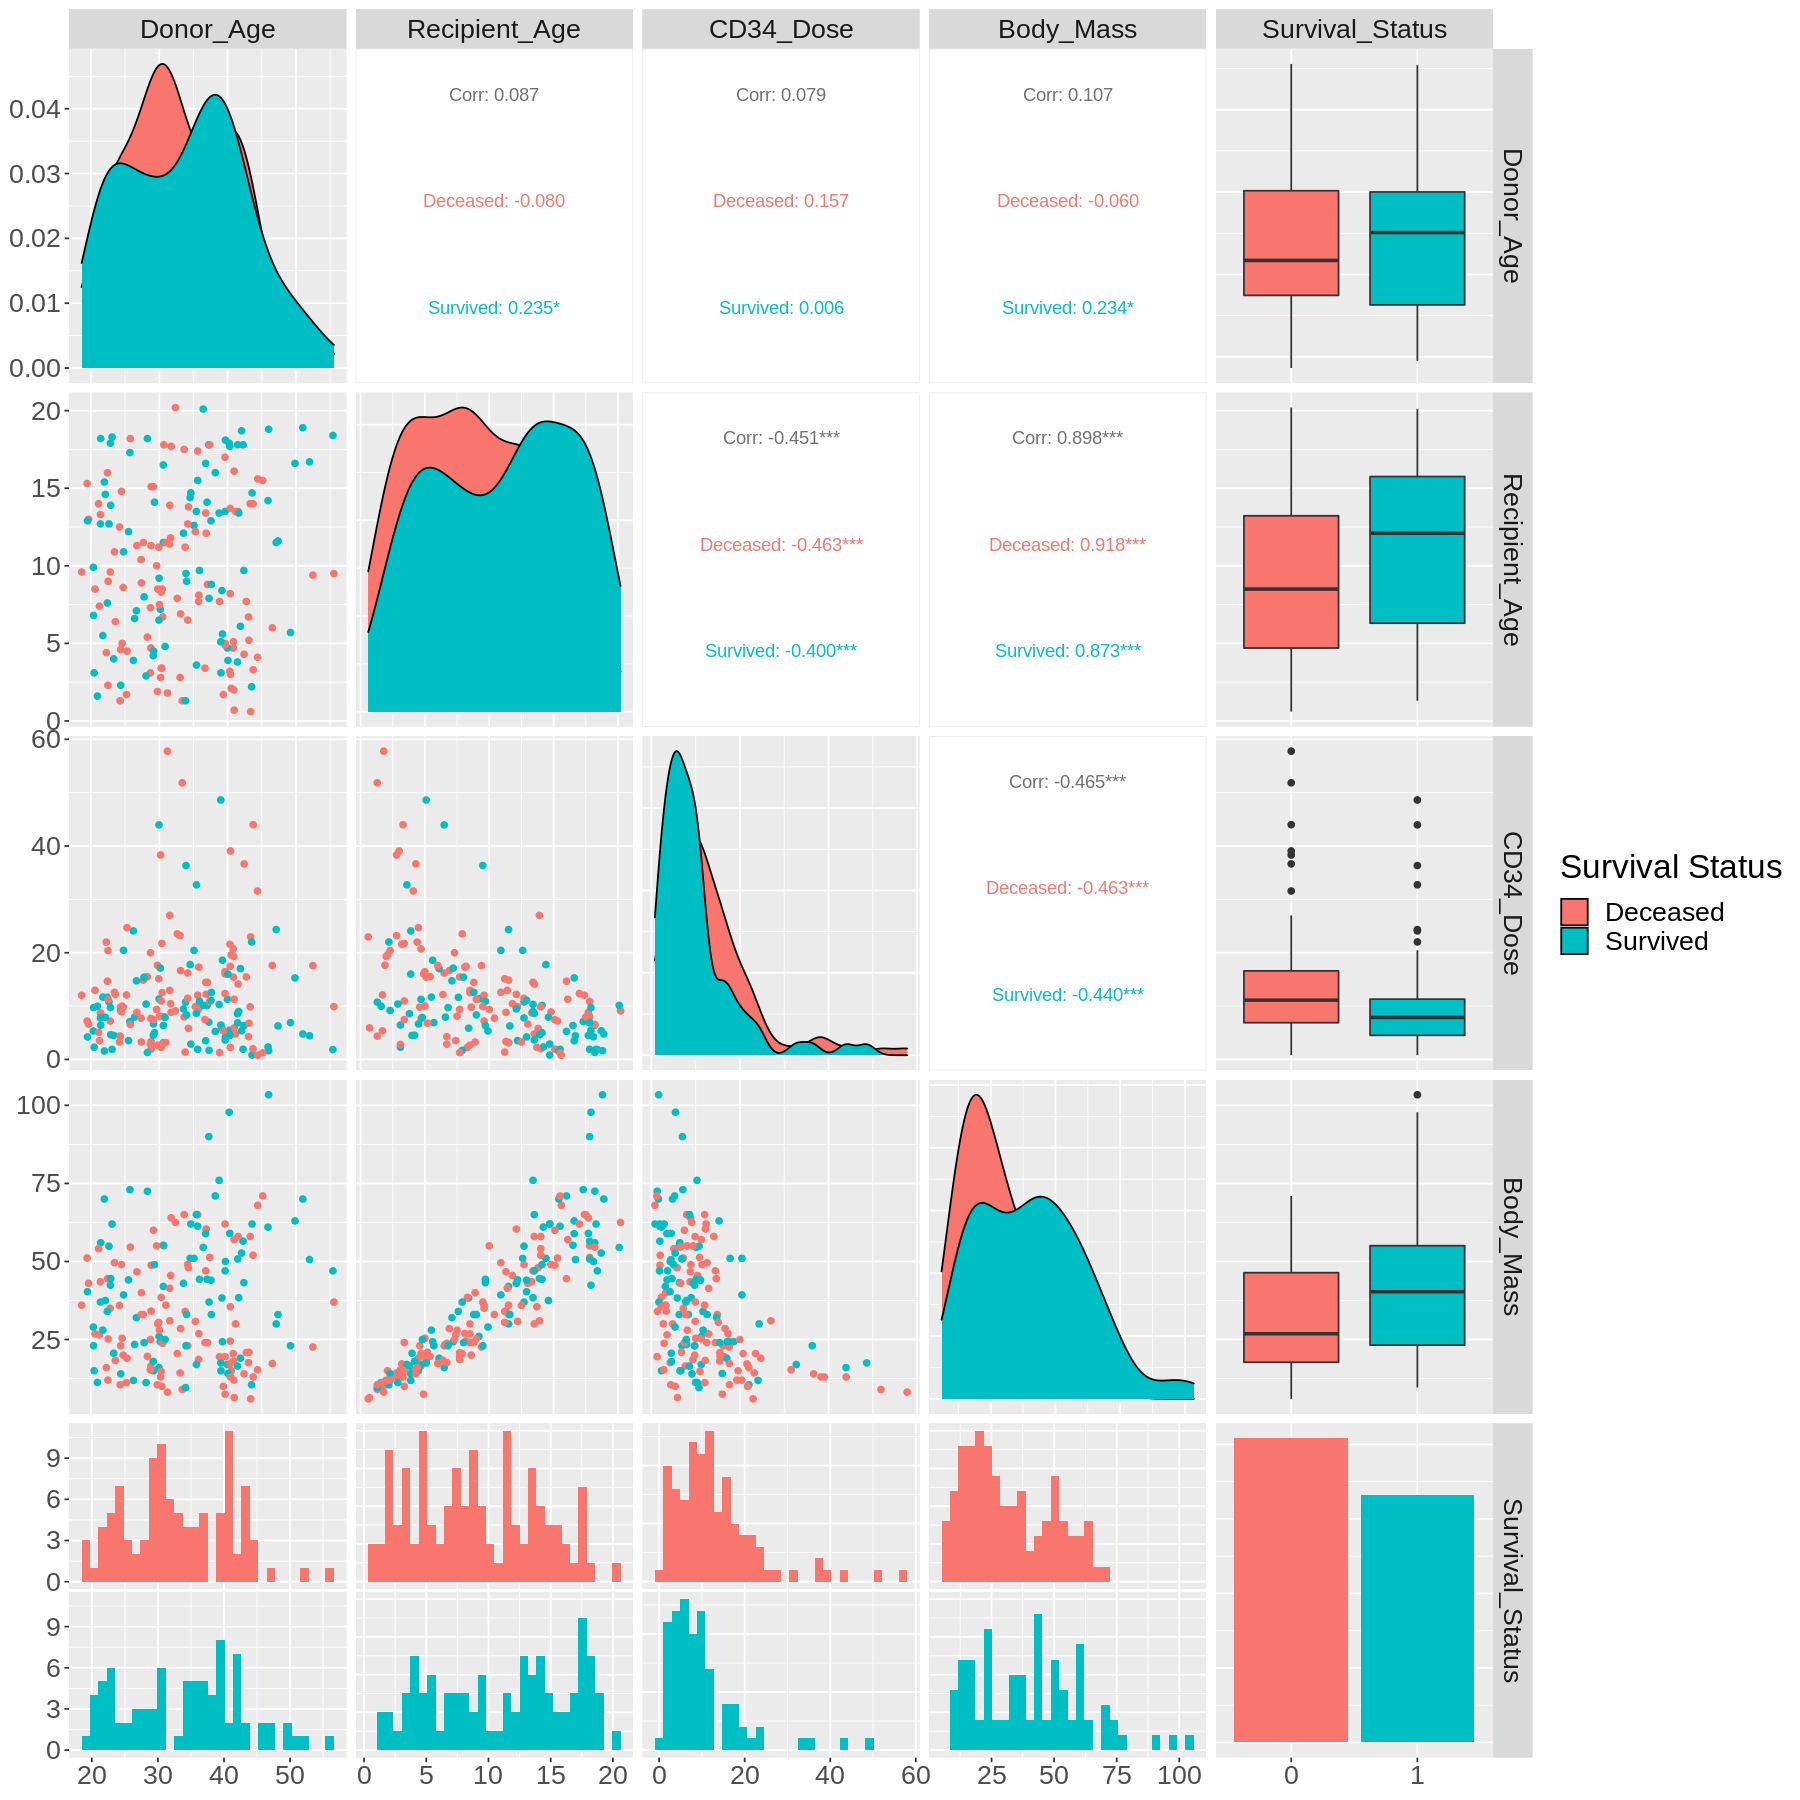

In [9]:
bone_marrow_clean |> ggpairs( legend = 1, 
                   aes(color = factor(Survival_Status, levels = 0:1, labels = c("Deceased", "Survived")))) + 
  theme(legend.position = "right",
       text = element_text(size = 20)) + 
  labs(fill = "Survival Status")

*Figure 5. Ggpairs plot containing each predictor and target variable*

Here, we created a ggpairs plot to compare each of our variables. We found that plotting different predictors against each other does not effectively distinguish between whether our patient will survive or not, as seen by the mostly random distribution of orange and blue points in the scatterplots. However, based on the box plots, we found that there was a difference in the medians between deceased and surviving patients, suggesting that each of the individual predictors may have an impact on whether or not a patient will survive.

In [10]:
#preprocessing the data
knn_recipe <- recipe(Survival_Status ~ CD34_Dose + Body_Mass + Donor_Age + Recipient_Age, data = bone_marrow_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification") 

Since we found that the units and scales of our predictors were all different, we first standardized our data using our training dataset. We used only the training dataset here in order to ensure that our testing data would not interfere with our model's perceived accuracy.

After this, we trained our classifier by setting the numbers of k-neighbors to tune so that we could use cross-validation to find and pick the best k-value to maximize the model's accuracy.

In [11]:
bone_marrow_vfold <- vfold_cv(bone_marrow_train, v = 5, strata = Survival_Status)

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bone_marrow_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5507845,5,0.03778157,Preprocessor1_Model01
2,accuracy,binary,0.5507845,5,0.03778157,Preprocessor1_Model02
3,accuracy,binary,0.5658639,5,0.02623108,Preprocessor1_Model03
4,accuracy,binary,0.5658639,5,0.02623108,Preprocessor1_Model04
5,accuracy,binary,0.5875753,5,0.03693430,Preprocessor1_Model05
6,accuracy,binary,0.5875753,5,0.03693430,Preprocessor1_Model06


*Table 6. Accuracy of the model based on k-nearest neighbors value*

First, we divided the data into 5 equally sized folds and set the strata to our target variable, Survival Status, to ensure that the training and testing data had proportions of deceased and survived patients that were approximately representative of the overall dataset. We did this to minimize the possibility of an unlucky validation set influencing our model's accuracy.

Then, we created a tibble containing sample k-values from 1 to 25 to determine which k-value would yield the greatest accuracy.

Finally, we put everything together by combining both the recipe and the model specification into a workflow and then using tune_grid and collect_metrics to find and clearly show the accuracy for each of the k-values.

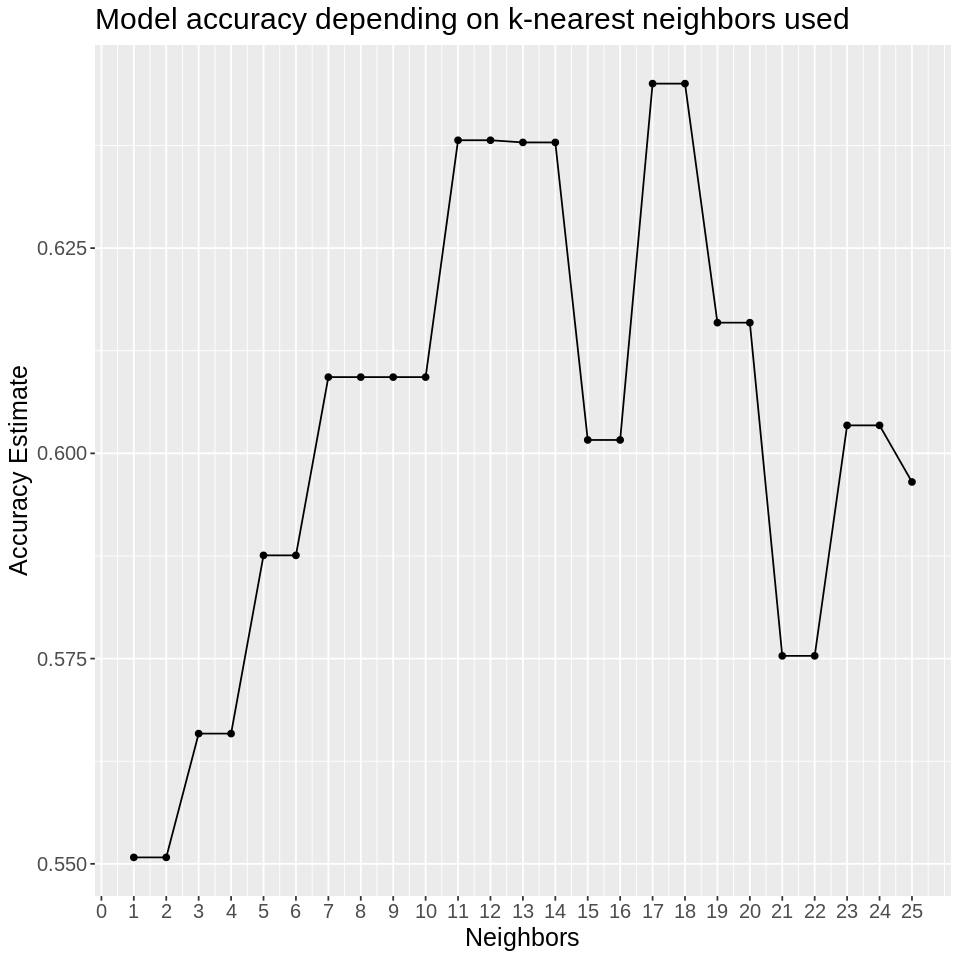

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 25, by = 1)) +
       ggtitle("Model accuracy depending on k-nearest neighbors used") +
       theme(text = element_text(size = 15))

accuracy_versus_k

*Figure 7. Visualization of model accuracy based on k-nearest neighbor value*

Here, we created a graph to visualize the the accuracies of each of the k-neighbors. We found that using 18 nearest neighbors would yield the greatest accuracy. We chose these values by determining from the graph the k-values that have the highest accuracy estimates, which in this case were 17 and 18, and then choosing the one that minimizes change in accuracy when adding or subtracting a neighbor.

In [13]:
bone_marrow_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
       set_engine("kknn") |>
       set_mode("classification")

bone_marrow_fit_resamples <- workflow() |>
       add_recipe(knn_recipe) |>
       add_model(bone_marrow_spec_best) |>
       fit_resamples(resamples = bone_marrow_vfold)

We created a new specification by setting the neighbors to the best k-value, which we determined to be 18, and put it together with the recipe in a new workflow. We also included fit_resamples to ensure that each of the folds were cross-validated.

In [14]:
bone_marrow_metrics <- bone_marrow_fit_resamples |>
        collect_metrics() |>
        filter(.metric == "accuracy")
bone_marrow_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6450374,5,0.02610929,Preprocessor1_Model1


*Table 8. Model accuracy based on training set data from cross-validation*

We found that the accuracy of the model derived from cross-validation was 64.5%.

In [15]:
bone_marrow_fit <- workflow() |>
       add_recipe(knn_recipe) |>
       add_model(bone_marrow_spec_best) |>
       fit(bone_marrow_train)

Finally, we fit the workflow with our recipe and the best specification model onto the training dataset.

In [16]:
bone_marrow_predictions <- predict(bone_marrow_fit, bone_marrow_test) |>
    bind_cols(bone_marrow_test)
head(bone_marrow_predictions)

.pred_class,Donor_Age,Recipient_Age,CD34_Dose,Body_Mass,Survival_Status
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,22.83014,9.6,7.20,35.0,0
1,39.68493,18.1,4.25,50.0,1
0,33.35890,1.3,51.85,9.0,0
0,21.43562,18.2,6.41,56.0,1
1,28.78356,4.7,7.69,16.5,0
0,29.73151,1.9,17.66,10.5,0


*Table 9. Model's predicted classes for testing dataset*

In order to test the accuracy of our model on new observations that it had not seen before, we used our model, bone_marrow_fit, to predict the survival status of the observations from the testing dataset. We displayed the testing dataset alongside the newly generated prediction column to display this more intuitively.

In [17]:
bone_marrow_test_accuracy <- bone_marrow_predictions |>
  metrics(truth = Survival_Status, estimate = .pred_class) |>
  filter(.metric == "accuracy")
bone_marrow_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5531915


*Table 10. Accuracy of model based on testing dataset*

We created a tibble to display the accuracy of our predictions by using the metric function and assigning truth to Survival Status and estimate to the .pred_class column. We found that the accuracy of the model was 55.3%.

In [18]:
bone_marrow_confusion <- bone_marrow_predictions |>
             conf_mat(truth = Survival_Status, estimate = .pred_class)
bone_marrow_confusion

          Truth
Prediction  0  1
         0 18 13
         1  8  8

*Table 11. Confusion matrix displaying true and predicted classes of testing dataset observations*

Here, we created a confusion matrix for our classifier using the actual Survival Status and the predictions of our model. We found that out of 47 observations, 26 were predicted correctly. 21 were predicted incorrectly, either misclassifying deceased patients as surviving or surviving patients as deceased.

### Discussion

&ensp; &ensp; Based on our exploratory data analysis, we found that there was no strong correlation between any two predictors and a patient’s survival status. Instead, the “deceased” and “survived” categories that made up the survival status appeared to be randomly interspersed between the variables, no matter which two predictors were plotted against each other, as depicted in figure 5. The differing medians for “survived” and “deceased” observations produced by the boxplots in figure 5 suggested that although distinct clusters were not observed when plotting any two predictor variables against each other, perhaps each individual predictor may have an impact on a patient’s survival status.  
&ensp; &ensp; However, this was not observed to be the case, as the accuracy of the model derived from cross-validation was only observed to be 64.5%, further dropping to an accuracy of 55.3% when tested on the testing set, thereby indicating how accurately the model would predict new observations. This final accuracy of 55.3% is approximately the same as the 55.1% proportion of the majority classifier, which in this case is the proportion of deceased patients. Thus, our model does not make a significant improvement in accuracy compared to a model which would guess “deceased” as the survival status of every patient.  
&ensp; &ensp; This is problematic when considering the medical context in which the model would be used. This model has applications in determining how to adapt medical treatment plans for patients based on their predicted survival status. If a patient was predicted to survive based on the predictors for that patient, the current regimen would be continued, whereas if a patient was predicted to die, the regimen would be altered to maximize survival chances. However, the model only classified 55.3% of observations correctly, implying that if practically applied to treat actual patients, 55.3% of these patients would receive improper treatment. This is particularly problematic in the 17% of cases in which the patient was predicted to survive when they actually would perish, as in this case, they would not receive the adaptations to their treatment plan that they would require in order to survive, and it would also instill false hope in the patient and their family.  
&ensp; &ensp; The results of this model do not align with our expectations derived from prior research. According to Sikora et al.’s study, certain combinations of predictor variables should be able to accurately classify a patient as deceased or alive. For instance, Sikora et al. found that if CD34+ dosage was between 1.265 x 10^6 and 10.815 x 10^6 cells per kg, recipient age was over 11.6 years, and donor age was over 20.5 years, the patient could be expected to perish with 95% accuracy. Additionally, Kałwak et al.’s study indicated that as CD34+ stem cell dosage increased, the chance of a patient’s survival would increase accordingly; however, no significant correlation was found between the two variables, and figure 5 suggests that there may in fact be a negative correlation between them.  
&ensp; &ensp; Based on this model, it appears that the predictor variables donor age, recipient age, CD34+ dosage, and recipient body mass are not sufficient to predict whether or not a patient will survive a bone marrow transplant. A limitation of this model that could explain the discrepancies between our results and those of the researchers could be that the k-nearest neighbors classification system only works with numerical predictor variables, whereas there may be certain categorical variables, such as the donor and recipient’s gender compatibility, which have greater influence on a patient’s survival. Therefore, further research must be conducted to conclusively determine which factors will actually be influential in determining a patient’s survival status. If this is achieved, it may have major implications in assisting doctors and medical personnel to adapt treatment regimens in order to improve survival outcomes for future patients.

Future questions that our project could pose are:
* How can the chances of survival of future patients be improved?
* How can the donor’s compatibility with the recipient be optimized?
* What are the main factors impacting a patient’s survival status?


### References

Kałwak, Krzysztof, et al. “Higher CD34+ and CD3+ Cell Doses in the Graft Promote Long-Term Survival, and Have No Impact on the Incidence of Severe Acute or Chronic Graft-versus-Host Disease after In Vivo T Cell-Depleted Unrelated Donor Hematopoietic Stem Cell Transplantation in Children.” *Biology of Blood and Marrow Transplantation*, vol. 16, no. 10, 2010,         pp. 1388–1401, https://doi.org/10.1016/j.bbmt.2010.04.001. 

Sikora, Marek, and Lukasz Wrobel. “Bone Marrow Transplant: Children.” *UCI Machine 
Learning Repository*, 20 Apr. 2020, https://doi.org/10.24432/C5NP6Z. 

Sikora, Marek, et al. “Application of Rule Induction to Discover Survival Factors of 
Patients after Bone Marrow Transplantation.” *Journal of Medical Informatics & Technologies*, vol. 22, no. 2013, Jan. 2013. 